In [1]:
import numpy as np
from scipy.stats import truncnorm
import gym
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding enviro

In [2]:
class CEM:
    def __init__(self, n_sequence, elite_ratio, fake_env, upper_bound,
                 lower_bound):
        '''
        Args:
        n_sequence: 动作序列的长度
        elite_ratio: 选取若干条动作序列的比例
        '''
        self.n_sequence = n_sequence
        self.elite_ratio = elite_ratio
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env

    def optimize(self, state, init_mean, init_var):
        mean, var = init_mean, init_var
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))
        state = np.tile(state, (self.n_sequence, 1))

        for _ in range(5):
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            constrained_var = np.minimum(
                np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)),
                var)
            # 生成动作序列
            action_sequences = [X.rvs() for _ in range(self.n_sequence)
                                ] * np.sqrt(constrained_var) + mean
            # 计算每条动作序列的累积奖励
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # 选取累积奖励最高的若干条动作序列
            elites = action_sequences[np.argsort(
                returns)][-int(self.elite_ratio * self.n_sequence):]
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 更新动作序列分布
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var

        return mean

首先，为了搭建这样一个较为复杂的模型，我们定义模型中每一层的构造。在定义时就必须考虑每一层都是一个集成。

In [3]:
class Swish(nn.Module):
    ''' Swish激活函数 '''
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


def init_weights(m):
    ''' 初始化模型权重 '''
    def truncated_normal_init(t, mean=0.0, std=0.01):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(
                cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),
                                      mean=mean,
                                      std=std), t)
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))
        m.bias.data.fill_(0.0)


class FCLayer(nn.Module):
    ''' 集成之后的全连接层 '''
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(
            torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self._activation = activation
        self.bias = nn.Parameter(
            torch.Tensor(ensemble_size, output_dim).to(device))

    def forward(self, x):
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))

接着，使用高斯分布的概率模型来定义一个集成模型。

In [4]:
class EnsembleModel(nn.Module):
    ''' 环境模型集成 '''
    def __init__(self,
                 state_dim,
                 action_dim,
                 ensemble_size=5,
                 learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        # 输出包括均值和方差,因此是状态与奖励维度之和的两倍
        self._output_dim = (state_dim + 1) * 2
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),
                                        requires_grad=False)
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),
                                        requires_grad=False)

        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size,
                              Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size,
                              nn.Identity())
        self.apply(init_weights)  # 初始化环境模型中的参数
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, return_log_var=False):
        ret = self.layer5(self.layer4(self.layer3(self.layer2(
            self.layer1(x)))))
        mean = ret[:, :, :self._output_dim // 2]
        # 在PETS算法中,将方差控制在最小值和最大值之间
        logvar = self._max_logvar - F.softplus(
            self._max_logvar - ret[:, :, self._output_dim // 2:])
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, mean, logvar, labels, use_var_loss=True):
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) *
                                             inverse_var,
                                             dim=-1),
                                  dim=-1)
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train(self, loss):
        self.optimizer.zero_grad()
        loss += 0.01 * torch.sum(self._max_logvar) - 0.01 * torch.sum(
            self._min_logvar)
        loss.backward()
        self.optimizer.step()

接下来，我们定义一个EnsembleDynamicsModel的类，把模型集成的训练设计得更加精细化。具体而言，我们并不会选择模型训练的轮数，而是在每次训练的时候将一部分数据单独取出来，用于验证模型的表现，在 5 次没有获得表现提升时就结束训练。

In [5]:
class EnsembleDynamicsModel:
    ''' 环境模型集成,加入精细化的训练 '''
    def __init__(self, state_dim, action_dim, num_network=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim,
                                   action_dim,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0

    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]
        holdout_inputs, holdout_labels = inputs[:
                                                num_holdout], labels[:
                                                                     num_holdout]
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        holdout_inputs = holdout_inputs[None, :, :].repeat(
            [self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat(
            [self._num_network, 1, 1])

        # 保留最好的结果
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}

        for epoch in itertools.count():
            # 定义每一个网络的训练数据
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])
            # 所有真实数据都用来训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):
                batch_index = train_index[:, batch_start_pos:batch_start_pos +
                                          batch_size]
                train_input = torch.from_numpy(
                    train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(
                    train_labels[batch_index]).float().to(device)

                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)
                self.model.train(loss)

            with torch.no_grad():
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(mean,
                                                    logvar,
                                                    holdout_labels,
                                                    use_var_loss=False)
                holdout_losses = holdout_losses.cpu()
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        updated = False
        for i in range(len(losses)):
            current = losses[i]
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, inputs, batch_size=64):
        mean, var = [], []
        for i in range(0, inputs.shape[0], batch_size):
            input = torch.from_numpy(
                inputs[i:min(i +
                             batch_size, inputs.shape[0])]).float().to(device)
            cur_mean, cur_var = self.model(input[None, :, :].repeat(
                [self._num_network, 1, 1]),
                                           return_log_var=False)
            mean.append(cur_mean.detach().cpu().numpy())
            var.append(cur_var.detach().cpu().numpy())
        return np.hstack(mean), np.hstack(var)

有了环境模型之后，我们就可以定义一个FakeEnv，主要用于实现给定状态和动作，用模型集成来进行预测。该功能会用在 MPC 算法中。

In [6]:
class FakeEnv:
    def __init__(self, model):
        self.model = model

    def step(self, obs, act):
        inputs = np.concatenate((obs, act), axis=-1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)
        ensemble_model_means[:, :, 1:] += obs.numpy()
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds

        num_models, batch_size, _ = ensemble_model_means.shape
        models_to_use = np.random.choice(
            [i for i in range(self.model._num_network)], size=batch_size)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        rewards, next_obs = samples[:, :1], samples[:, 1:]
        return rewards, next_obs

    def propagate(self, obs, actions):
        with torch.no_grad():
            obs = np.copy(obs)
            total_reward = np.expand_dims(np.zeros(obs.shape[0]), axis=-1)
            obs, actions = torch.as_tensor(obs), torch.as_tensor(actions)
            for i in range(actions.shape[1]):
                action = torch.unsqueeze(actions[:, i], 1)
                rewards, next_obs = self.step(obs, action)
                total_reward += rewards
                obs = torch.as_tensor(next_obs)
            return total_reward

接下来定义经验回放池的类Replay Buffer。与之前的章节对比，此处经验回放缓冲区会额外实现一个返回所有数据的函数。

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

接下来是 PETS 算法的主体部分。

In [8]:
class PETS:
    ''' PETS算法 '''
    def __init__(self, env, replay_buffer, n_sequence, elite_ratio,
                 plan_horizon, num_episodes):
        '''
        Args:
        n_sequence: 序列长度
        elite_ratio: 选择elite_ratio的策略
        plan_horizon: 计划的时间步数
        num_episodes: 训练的次数
        '''
        self._env = env
        self._env_pool = ReplayBuffer(buffer_size)

        obs_dim = env.observation_space.shape[0]
        self._action_dim = env.action_space.shape[0]
        self._model = EnsembleDynamicsModel(obs_dim, self._action_dim)
        self._fake_env = FakeEnv(self._model)
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]

        self._cem = CEM(n_sequence, elite_ratio, self._fake_env,
                        self.upper_bound, self.lower_bound)
        self.plan_horizon = plan_horizon
        self.num_episodes = num_episodes

    def train_model(self):
        env_samples = self._env_pool.return_all_samples()
        obs = env_samples[0]
        actions = np.array(env_samples[1])
        rewards = np.array(env_samples[2]).reshape(-1, 1)
        next_obs = env_samples[3]
        inputs = np.concatenate((obs, actions), axis=-1)
        labels = np.concatenate((rewards, next_obs - obs), axis=-1)
        self._model.train(inputs, labels)

    def mpc(self):
        mean = np.tile((self.upper_bound + self.lower_bound) / 2.0,
                       self.plan_horizon)
        var = np.tile(
            np.square(self.upper_bound - self.lower_bound) / 16,
            self.plan_horizon) #? 为什么除以16
        obs, done, episode_return = self._env.reset(), False, 0
        while not done:
            actions = self._cem.optimize(obs, mean, var)
            action = actions[:self._action_dim]  # 选取第一个动作
            next_obs, reward, done, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
            mean = np.concatenate([
                np.copy(actions)[self._action_dim:],
                np.zeros(self._action_dim)
            ])
        return episode_return

    def explore(self):
        obs, done, episode_return = self._env.reset(), False, 0
        while not done:
            action = self._env.action_space.sample()
            next_obs, reward, done, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self):
        return_list = []
        explore_return = self.explore()  # 先进行随机策略的探索来收集一条序列的数据
        print('episode: 1, return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episodes - 1):
            self.train_model()
            episode_return = self.mpc()
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list

episode: 1, return: -860
episode: 2, return: -882
episode: 3, return: -1295
episode: 4, return: -126
episode: 5, return: -383
episode: 6, return: -123
episode: 7, return: -488
episode: 8, return: -260
episode: 9, return: -463
episode: 10, return: -248
episode: 11, return: -253
episode: 12, return: -119
episode: 13, return: -119
episode: 14, return: -248
episode: 15, return: -400
episode: 16, return: -255
episode: 17, return: -121
episode: 18, return: -124
episode: 19, return: -122
episode: 20, return: -120
episode: 21, return: -250
episode: 22, return: -417
episode: 23, return: -125
episode: 24, return: -346
episode: 25, return: -2
episode: 26, return: -123
episode: 27, return: -261
episode: 28, return: -300
episode: 29, return: -375
episode: 30, return: -119
episode: 31, return: -120
episode: 32, return: -126
episode: 33, return: -124
episode: 34, return: -122
episode: 35, return: -411
episode: 36, return: -127
episode: 37, return: -1
episode: 38, return: -121
episode: 39, return: -12

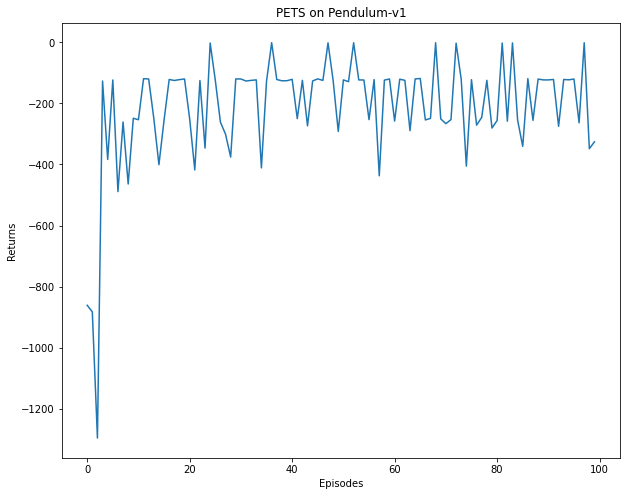

In [9]:
buffer_size = 100000
n_sequence = 50
elite_ratio = 0.2
plan_horizon = 25 # task horizon
num_episodes = 100 # 10
env_name = 'Pendulum-v1'
env = gym.make(env_name)

replay_buffer = ReplayBuffer(buffer_size)
pets = PETS(env, replay_buffer, n_sequence, elite_ratio, plan_horizon,
            num_episodes)
return_list = pets.train()

episodes_list = list(range(1, len(return_list)+1))
plt.figure(figsize=(10, 8))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PETS on {}'.format(env_name))
plt.show()

# episode: 1, return: -1062
# episode: 2, return: -1257
# episode: 3, return: -1792
# episode: 4, return: -1225
# episode: 5, return: -248
# episode: 6, return: -124
# episode: 7, return: -249
# episode: 8, return: -269
# episode: 9, return: -245
# episode: 10, return: -119

In [10]:
print(episodes_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
